## Processing DeWeirdt 2020 Gattinara
- Processing Gattinara screen from [DeWeirdt 2020](https://www.nature.com/articles/s41467-020-14620-6)
- A375
- Library design: sgRNAs were ranked by CRISPick

### Data Filters
1. pdna or etp > mean pdna -3 std
2. sgRNAs targetting essential genes
3. Match bin 1, tier 1 score of 0

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gpplot
from poola import core as pool

In [2]:
reads = pd.read_csv('../data/raw/DeWeirdt2020_S1_Gattinara.csv')
essential_genes = pd.read_table('https://raw.githubusercontent.com/gpp-rnd/genesets/master/human/essential-genes-Hart2015.txt',
                                names=['GENE'])
nonessential_genes = pd.read_table('https://raw.githubusercontent.com/gpp-rnd/genesets/master/human/non-essential-genes-Hart2014.txt',
                                   names=['GENE'])

In [3]:
lognorms = pool.lognorm_columns(reads, columns=['pDNA', 'A375_Dropout_RepA', 'A375_Dropout_RepB'])
filtered_lognorms = pool.filter_pdna(lognorm_df=lognorms, pdna_cols=['pDNA'])
print('Filtered ' + str(lognorms.shape[0] - filtered_lognorms.shape[0]) + ' rows due to low pDNA abundance')

Filtered 215 rows due to low pDNA abundance


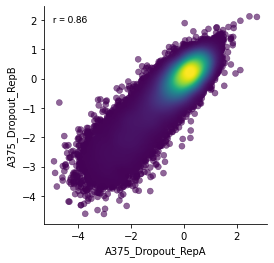

In [4]:
lfc_df = pool.calculate_lfcs(lognorm_df=filtered_lognorms, ref_col='pDNA', target_cols=['A375_Dropout_RepA', 'A375_Dropout_RepB'])
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=lfc_df, x='A375_Dropout_RepA', y='A375_Dropout_RepB')
gpplot.add_correlation(data=lfc_df, x='A375_Dropout_RepA', y='A375_Dropout_RepB')
sns.despine()

In [5]:
avg_replicate_lfc_df = pool.average_replicate_lfcs(lfcs=lfc_df, guide_col='Construct Barcode', condition_indices=[0],
                                                   lfc_cols=['A375_Dropout_RepA', 'A375_Dropout_RepB'], sep='_')

In [6]:
sg_list = list(avg_replicate_lfc_df['Construct Barcode'].unique())
design_df = pd.read_parquet('/Volumes/GoogleDrive/Shared drives/GPP Cloud /R&D/People/Peter/gpp-annotation-files/sgRNA_design_9606_GRCh38_SpyoCas9_CRISPRko_Ensembl_20200401.parquet',
                            filters=[[('sgRNA Sequence', 'in', sg_list)]])

In [7]:
lfcs_designs = (avg_replicate_lfc_df.rename({'Construct Barcode': 'sgRNA Sequence'}, axis=1)
                .merge(design_df, how = 'inner', on = 'sgRNA Sequence'))
roc_aucs, _ = pool.get_roc_aucs(lfcs=lfcs_designs, tp_genes=essential_genes.GENE,
                                fp_genes=nonessential_genes.GENE, gene_col='Target Gene Symbol',
                                score_col='avg_lfc', condition_col='condition')
roc_aucs

,condition,ROC-AUC
0,A375,0.935238


We'll filter for genes that have at least 2 guides

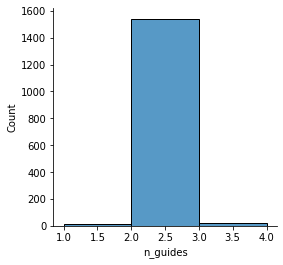

In [8]:
ess_lfcs = lfcs_designs[lfcs_designs['Target Gene Symbol'].isin(essential_genes.GENE)]
essential_gene_count = (ess_lfcs['Target Gene Symbol'].value_counts()
                        .reset_index(name='n_guides')
                        .rename({'index': 'gene'}, axis=1))
plt.subplots(figsize=(4,4))
sns.histplot(essential_gene_count['n_guides'], binwidth=1)
sns.despine()

In [9]:
relevant_essential_genes = essential_gene_count.gene[essential_gene_count.n_guides >= 2]
filtered_ess_lfcs = ess_lfcs[ess_lfcs['Target Gene Symbol'].isin(relevant_essential_genes)]

In [10]:
filtered_sgs = filtered_ess_lfcs[(filtered_ess_lfcs['# Off-Target Tier I Match Bin I Matches'] == '0')].copy()
print('Off target filtered: ' + str(filtered_ess_lfcs.shape[0] - filtered_sgs.shape[0]))

Off target filtered: 146


In [11]:
filtered_sgs['mean_centered_neg_lfc'] = (filtered_sgs.groupby(['Target Gene Symbol'])
                                         .avg_lfc
                                         .transform(lambda x: -(x - x.mean())))
filtered_sgs = filtered_sgs[['sgRNA Sequence', 'sgRNA Context Sequence', 'Target Gene Symbol',
                             'Target Cut %', 'On-Target Efficacy Score', 'mean_centered_neg_lfc']]

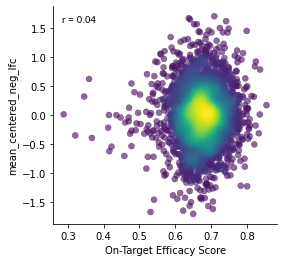

In [12]:
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=filtered_sgs, x='On-Target Efficacy Score', y='mean_centered_neg_lfc')
gpplot.add_correlation(data=filtered_sgs, x='On-Target Efficacy Score', y='mean_centered_neg_lfc', method='pearson')
sns.despine()

## Output

In [13]:
output_df = filtered_sgs.drop('On-Target Efficacy Score', axis=1)
output_df

,sgRNA Sequence,sgRNA Context Sequence,Target Gene Symbol,Target Cut %,mean_centered_neg_lfc
24,AAAAACCTGGTCATGAACAC,ACTGAAAAACCTGGTCATGAACACTGGACC,RPP40,16.9,0.135372
37,AAAAAGCTGAAGCAGAGTCA,CACTAAAAAGCTGAAGCAGAGTCAAGGAAT,HAUS3,24.9,-0.164418
75,AAAACAGAGACTCAGCAAGG,AAGCAAAACAGAGACTCAGCAAGGTGGTAA,ATP6V1E1,45.5,0.172507
83,AAAACCAGCTTTAATCACAC,CAGCAAAACCAGCTTTAATCACACCGGATC,ACTR1A,5.1,0.154777
103,AAAACTGGAAGAGACCAGAG,GATTAAAACTGGAAGAGACCAGAGAGGTAC,C9orf78,11.8,0.244689
...,...,...,...,...,...
40803,TTTGGTGAAAGGTCACGATA,CGGTTTTGGTGAAAGGTCACGATAAGGCTG,MRPS10,41.3,0.089223
40807,TTTGTAAGTGATCTGAAGCG,TTGCTTTGTAAGTGATCTGAAGCGAGGACT,ACTR10,52.8,1.020812
40812,TTTGTATACCCCATGGACCT,TCTTTTTGTATACCCCATGGACCTGGGGGG,NDUFB6,46.8,-0.040543
40833,TTTGTGAGACATGTGAAAGG,GAAATTTGTGAGACATGTGAAAGGAGGACA,SLC39A7,51.2,-0.328419


In [14]:
output_df.to_csv('../data/processed/DeWeirdt2020_gattinara_activity.csv', index=False)